# Analyze inductive inference task data

In [1]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks
from tesser import figures

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

## Temporal bias for each trial type

In [2]:
induct = tasks.load_induct(data_dir)
induct.head()

,subject,trial,trial_type,environment,community,cue,opt1,opt2,within,response,response_time,correct
0,100,1,central,ocean,1,2,16,20,2,NaN,NaN,NaN
1,100,2,boundary2,desert,2,4,10,19,1,2.0,2.974157,0.0
2,100,3,central,desert,2,5,6,2,1,1.0,3.190848,1.0
3,100,4,central,ocean,1,2,9,19,2,2.0,3.373906,1.0
4,100,5,central,ocean,1,1,19,13,1,2.0,3.094699,0.0


In [3]:
bias = (induct.groupby(['subject', 'trial_type'])[['correct']].mean() - .5) * 2
bias = bias.reset_index()

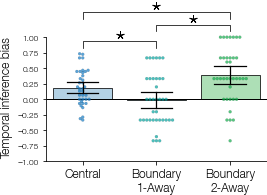

In [4]:
colors = figures.get_induct_colors()
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    bias,
    x='trial_type',
    y='correct',
    dark=colors['dark'],
    light=colors['light'],
    point_kws={'clip_on': False},
    ax=ax,
)
ax.set(
    ylim=(-1, 1), ylabel='Temporal inference bias',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away']
)
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k')
ax.set_xlim(*x_lim);
x = sorted([p.get_x() + p.get_width() / 2 for p in ax.patches])
y = bias.groupby('trial_type')['correct'].max().to_list()
offset = 0.05 * np.diff(ax.get_ylim())
ax.set(ylim=(-1, 1.6), yticks=np.arange(-1, 1.25, .25))
ax.spines['left'].set_bounds(-1, 1)
statplot.plot_sig([x[0], x[1]], [y[0], y[1]], offset, ax=ax)
statplot.plot_sig([x[1], x[2]], [y[1], y[2]], offset, ax=ax)
statplot.plot_sig([x[0], x[2]], [y[0] + offset * 2, y[2] + offset * 2], offset, ax=ax)
ax.yaxis.set_label_coords(-.15, 0.4)
fig.savefig(os.path.join(fig_dir, 'temporal_bias.pdf'))

### Is there significant temporal bias?

In [44]:
mat = pd.pivot(
    data=bias, index='subject', columns='trial_type', values='correct'
)
stats = pd.concat(
    [pg.ttest(mat[col], 0) for col in mat.columns], axis=0, keys=mat.columns
)
stats

,,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
trial_type,,,,,,,,,
boundary1,T-test,-0.182485,36,two-sided,0.856226,"[-0.15, 0.13]",0.030000,0.18,0.053624
boundary2,T-test,5.287677,36,two-sided,0.000006,"[0.24, 0.53]",0.869289,3159.569,0.999269
central,T-test,3.967068,36,two-sided,0.000332,"[0.09, 0.28]",0.652182,83.77,0.971232


### Does temporal bias vary by trial type?

In [5]:
pg.rm_anova(data=bias, dv='correct', within='trial_type', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,trial_type,2,72,14.270354,0.000006,0.283872,0.88351


In [45]:
pg.pairwise_ttests(
    data=bias, dv='correct', within='trial_type', subject='subject'
)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,trial_type,boundary1,boundary2,True,True,-4.735596,36.0,two-sided,0.000034,669.792,-0.909924
1,trial_type,boundary1,central,True,True,-3.297114,36.0,two-sided,0.002204,15.542,-0.546255
2,trial_type,boundary2,central,True,True,2.581411,36.0,two-sided,0.014059,3.14,0.528246


## Relationship between trial types

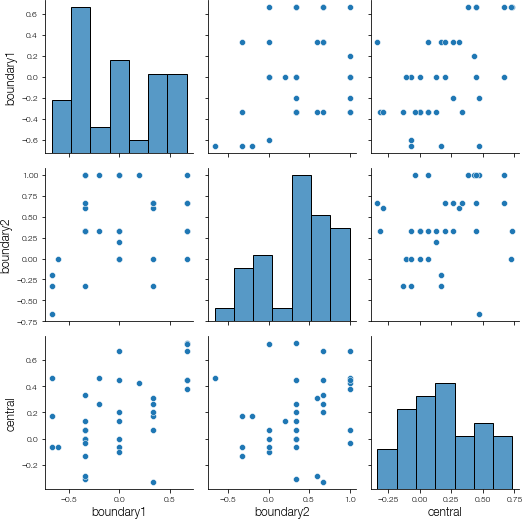

In [8]:
mat = pd.pivot(data=bias, index='subject', columns='trial_type', values='correct')
sns.pairplot(mat);

In [9]:
pg.pairwise_corr(mat)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,boundary1,boundary2,pearson,two-sided,37,0.302836,"[-0.02, 0.57]",0.091710,0.038281,0.312639,0.068470,1.011,0.453870
1,boundary1,central,pearson,two-sided,37,0.518604,"[0.23, 0.72]",0.268950,0.225947,0.574428,0.001008,37.131,0.923338
2,boundary2,central,pearson,two-sided,37,0.229350,"[-0.1, 0.52]",0.052601,-0.003128,0.233503,0.172102,0.502,0.280207


## Response time for each trial type

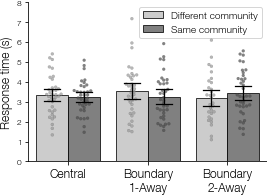

In [52]:
rt = induct.groupby(['trial_type', 'correct', 'subject'])['response_time'].mean()
rt = rt.reset_index()
dark = [(.6, .6, .6), (.3, .3, .3)]
light = [(.8, .8, .8), (.5, .5, .5)]
rt['Response'] = rt['correct'].map({0: 'Different community', 1: 'Same community'})
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    rt,
    x='trial_type',
    y='response_time',
    hue='Response',
    dark=dark,
    light=light,
    dodge=True,
    bar_kws={'capsize': .2},
    ax=ax,
)
ax.set(
    ylim=(0, 8),
    ylabel='Response time (s)',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away']
);
fig.savefig(os.path.join(fig_dir, 'temporal_bias_rt.pdf'))

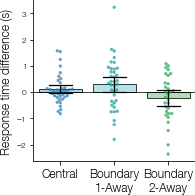

In [53]:
mrt = induct.groupby(['correct', 'trial_type', 'subject'])['response_time'].mean()
diff = (mrt.loc[0] - mrt.loc[1]).reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
statplot.plot_swarm_bar(
    diff,
    x='trial_type',
    y='response_time',
    dark=colors['dark'],
    light=colors['light'],
    ax=ax,
);
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
ax.set(
    ylabel='Response time difference (s)',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away']
);
fig.savefig(os.path.join(fig_dir, 'temporal_bias_rt_diff.pdf'))

### Is response time different for within- vs. across-community responses?

In [49]:
mat = pd.pivot(
    data=diff, index='subject', columns='trial_type', values='response_time'
)
stats = pd.concat(
    [pg.ttest(mat[col], 0) for col in mat.columns], axis=0, keys=mat.columns
)
stats

,,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
trial_type,,,,,,,,,
central,T-test,1.155108,36,two-sided,0.255656,"[-0.08, 0.29]",0.189899,0.327,0.202734
boundary1,T-test,1.930564,36,two-sided,0.061443,"[-0.02, 0.61]",0.317383,0.936,0.467791
boundary2,T-test,-1.413793,29,two-sided,0.168068,"[-0.55, 0.1]",0.258122,0.477,0.277093


### Does response time difference vary by trial type?

In [50]:
pg.rm_anova(
    data=diff,
    dv='response_time',
    subject='subject',
    within='trial_type',
)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,trial_type,2,58,4.287308,0.018343,0.128797,0.884391


In [51]:
pg.pairwise_ttests(
    data=diff,
    dv='response_time',
    subject='subject',
    within='trial_type',
)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,trial_type,boundary1,boundary2,True,True,2.507702,29.0,two-sided,0.018002,2.75,0.674984
1,trial_type,boundary1,central,True,True,1.513675,29.0,two-sided,0.140932,0.542,0.376937
2,trial_type,boundary2,central,True,True,-1.717115,29.0,two-sided,0.096622,0.717,-0.472283


In [7]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.13.0

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

matplotlib: 3.4.1
tesser    : 0.1.0
scipy     : 1.4.1
mindstorm : 0.8.0
seaborn   : 0.11.1
pingouin  : 0.3.11
numpy     : 1.18.1

